In [ ]:
""" Uncomment and Download data for training (6.1 GB) """
!wget http://images.cocodataset.org/zips/test2017.zip
!mkdir './dataset'
!unzip -q ./test2017.zip -d './dataset'

--2023-12-16 02:08:49--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.47.124, 52.217.125.33, 52.217.81.196, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.47.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘test2017.zip’

test2017.zip        100%[===================>]   6.19G  13.6MB/s    in 7m 57s  

2023-12-16 02:16:46 (13.3 MB/s) - ‘test2017.zip’ saved [6646970404/6646970404]



In [ ]:
""" Download content and style images """
!mkdir ./content
!mkdir ./style
!wget -q https://github.com/myelinfoundry-2019/challenge/raw/master/japanese_garden.jpg -P './content'
!wget -q https://github.com/myelinfoundry-2019/challenge/raw/master/picasso_selfportrait.jpg -P './style'

In [ ]:
import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2
import math
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True

# seed_everything(42)
device = torch.device("cuda")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
class VGG19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG19, self).__init__()
        self.model = models.vgg19(pretrained=True).features

        for i, _ in enumerate(self.model):
          if i in[4, 9, 18, 27]:
            self.model[i] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()

        for x in range(4):
            self.slice1.add_module(str(x), self.model[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), self.model[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), self.model[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), self.model[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)

        return out

class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)

class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

In [ ]:
def gram_matrix(y):
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram

def train_transform(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((int(image_size * 1.15),int(image_size * 1.15))),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform

def style_transform(image_size=None):
    resize = [transforms.Resize((image_size,image_size))] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def test_transform(image_size=None):
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def denormalize(tensors):
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors

def deprocess(image_tensor):
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np

In [ ]:
def tensor_to_img(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

In [ ]:
image_size=256
style_size=None
batch_size = 4
lr = 0.0005 #1e-5
epochs = 1
lambda_style= 10e9
lambda_style_layers = [10e2, 10e2, 10e8, 10e9]
lambda_content=10e1
lambda_tv = 0

In [ ]:
def fast_trainer(style_image,
                 dataset_path,
                 use_subset,
                 subset_size = 5000):

    os.makedirs(f"./checkpoints", exist_ok=True)

    train_dataset = datasets.ImageFolder(dataset_path, train_transform(image_size))
    dataloader = None
    if use_subset:
      train_dataset = torch.utils.data.Subset(train_dataset, random.sample(range(len(train_dataset)), subset_size))
    dataloader = DataLoader(train_dataset, batch_size=batch_size)

    transformer = TransformerNet().to(device)
    vgg = VGG19(requires_grad=False).to(device)

    optimizer = Adam(transformer.parameters(), lr)
    l2_loss = torch.nn.MSELoss().to(device)

    style = style_transform(style_size)(Image.open(style_image).convert('RGB'))
    style = style.repeat(batch_size, 1, 1, 1).to(device)
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

    image_samples = []
    for path in random.sample(glob.glob(f"{dataset_path}/*/*.jpg"), 8):
        image_samples += [style_transform(image_size)(Image.open(path))]
    image_samples = torch.stack(image_samples)

    train_metrics = {"content": [], "style": [], "total": []}
    for epoch in range(epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()
            images_original = images.to(device)
            images_transformed = transformer(images_original)

            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            content_loss = lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            style_loss = 0
            i = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :]) * lambda_style_layers[i]
                i += 1
            #style_loss *= lambda_style

            total_variation_loss = lambda_tv * (torch.sum(torch.abs(images_transformed[:, :, :, :-1] - images_transformed[:, :, :, 1:])) + torch.sum(torch.abs(images_transformed[:, :, :-1, :] - images_transformed[:, :, 1:, :])))

            total_loss = content_loss + style_loss + total_variation_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]

            train_metrics["content"] += [content_loss.item()]
            train_metrics["style"] += [style_loss.item()]
            train_metrics["total"] += [total_loss.item()]

            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    epochs,
                    batch_i,
                    (len(train_dataset) / batch_size) - 1,
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )
    plt.plot(train_metrics["content"], label = "Content Loss")
    plt.plot(train_metrics["style"], label = "Style Loss")
    plt.plot(train_metrics["total"], label = "Total Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()
    torch.save(transformer.state_dict(), f"./checkpoints/last_checkpoint.pth")

In [ ]:
def test_image(image_path,model,save_path):
    os.makedirs(os.path.join(save_path,"results"), exist_ok=True)

    transform = test_transform()
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(model))
    transformer.eval()

    image_tensor = Variable(transform(Image.open(image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()
    fn = model.split('/')[-1].split('.')[0]
    save_image(stylized_image, os.path.join(save_path,f"results/{fn}-output.jpg"))
    print("Image Saved!")
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(save_path,f"results/{fn}-output.jpg")), cv2.COLOR_BGR2RGB))

In [ ]:
import gc
del device
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

11302

In [ ]:
device = torch.device("cuda")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:29<00:00, 19.5MB/s]


[Epoch 1/1] [Batch 10167/10166] [Content: 89.97 (185.48) Style: 47.21 (64.25) Total: 137.19 (249.72)]

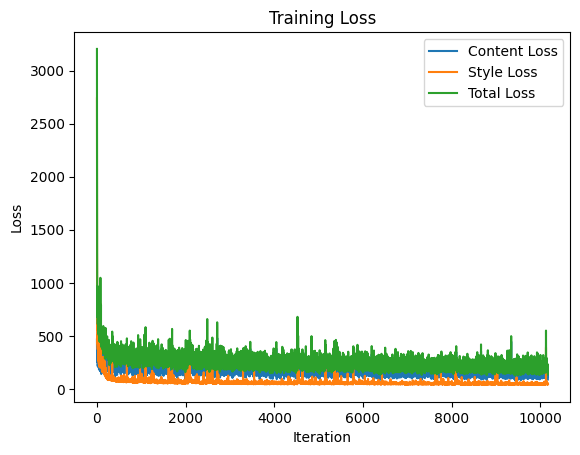

In [ ]:
fast_trainer(style_image='/content/style/bollinger-2.jpg',
             dataset_path='./dataset',
             use_subset = False)

Image Saved!


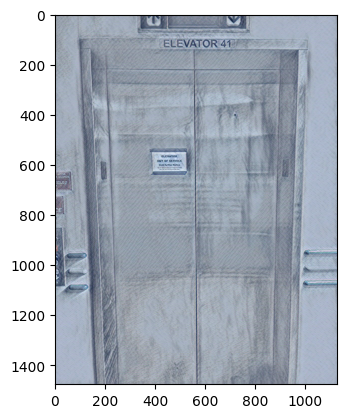

In [ ]:
test_image(image_path = '/content/content/elevator.jpg',
           model = './checkpoints/last_checkpoint.pth',
           save_path = './')

video processing:

In [ ]:
import cv2
import os
os.environ["OPENCV_FFMPEG_CAPTURE_OPTIONS"] = "rtsp_transport;udp"

def extract_frames(video_path, frame_interval=1):

    os.makedirs('content/frames', exist_ok=True)

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_count = 0
    output_frames = []
    frames_img = []

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        if frame_count % frame_interval == 0:
            cv2.imwrite(f"content/frames/frame_{frame_count}.jpg", frame)
            output_frames.append(frame)
            frames_img.append("content/frames/frame_{}.jpg".format(frame_count))

        frame_count += 1

    cap.release()

    return output_frames, frames_img

In [ ]:
def test_frame(image_path, model, save_path):
    os.makedirs(os.path.join(save_path,"results/frames"), exist_ok=True)
    transform = test_transform()
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(model))
    transformer.eval()

    image_tensor = Variable(transform(Image.open(image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()
    fn = model.split('/')[-1].split('.')[0]
    frame_path = image_path.split('/')[-1]
    save_image(stylized_image, os.path.join(save_path,f"results/frames/stylized_{frame_path}"))
    print("Image Saved!")
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(save_path,f"results/frames/stylized_{frame_path}")), cv2.COLOR_BGR2RGB))
    return cv2.imread(os.path.join(save_path,f"results/frames/stylized_{frame_path}"))

In [ ]:
def stitch_video(input_path, frames, width, height, output_path):
  cap = cv2.VideoCapture(input_path)
  fps = cap.get(cv2.CAP_PROP_FPS)

  codec = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(output_path, codec, fps, (width, height))

  for f in frames:
      out.write(f)

  out.release()
  cap.release()
  #cv2.destroyAllWindows()

In [ ]:
!rm -rf content/frames

In [ ]:
test_video = 'content/230.mp4'
output_path = 'results/230-stylized.mp4'
frames, frames_path = extract_frames(test_video)
fps = cv2.VideoCapture(test_video).get(cv2.CAP_PROP_FPS)

In [ ]:
!rm -rf results/frames

In [ ]:
stylized_frames = [test_frame(f, './checkpoints/last_checkpoint.pth', './') for f in frames_path]

In [ ]:
height, width, _ = stylized_frames[0].shape
stitch_video(test_video, stylized_frames, width, height, output_path)

In [ ]:
!zip -r stylized-frames.zip results/frames

benchmark:

In [ ]:
import timeit
import torch.utils.benchmark as benchmark

t0 = benchmark.Timer(
    stmt='test_image(image_path, model, save_path)',
    setup='from __main__ import test_image',
    globals={'image_path': '/content/content/230-window.jpg',
             'model': './checkpoints/last_checkpoint.pth',
             'save_path': './'})

print(t0.timeit(100))